# Experiment with Table Transformer Model

Walking through Table Transformer tutorial:
- [x] get metadata and filter for a file with an Ex. 21
- [x] convert to image
- [x] apply DetrFeaturePreprocessor to get encoding
- [x] load model and pass encoding into model
- [x] visualize the results, has the model found the table?
- [x] use "microsoft/table-transformer-structure-recognition" to actually extract the table
- [x] try to get the extracted tables into a dataframe
- [ ] try with the [facebook table extractor model](https://huggingface.co/facebook/rag-token-base)

In [1]:
# check to make sure transformers and torch are installed
!python -c "from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))"

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
[{'label': 'POSITIVE', 'score': 0.9998704195022583}]


In [117]:
from PIL import Image
from html2image import Html2Image
from transformers import DetrImageProcessor, TableTransformerForObjectDetection
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import easyocr
from tqdm.auto import tqdm

Convert HTML file to image

* this only takes a screenshot of the first page, so it doesn't really work. For now, just take an example screenshot of an Ex. 21

In [33]:
# Path to your HTML file
html_file = "trans_lux_corp.html"

hti = Html2Image()
# Convert HTML to image
image_paths = hti.screenshot(
    html_file=html_file,
    save_as='trans_lux_corp_test.png'
)
image = Image.open(image_paths[0]).convert("RGB")

[0324/210925.526150:WARNING:runtime_features.cc(728)] AttributionReportingCrossAppWeb cannot be enabled in this configuration. Use --enable-features=ConversionMeasurement,AttributionReportingCrossAppWeb in addition.
[0324/210925.554158:WARNING:runtime_features.cc(728)] AttributionReportingCrossAppWeb cannot be enabled in this configuration. Use --enable-features=ConversionMeasurement,AttributionReportingCrossAppWeb in addition.
567788 bytes written to file /Users/katielamb/CatalystCoop/mozilla-sec-eia/notebooks/trans_lux_corp_test.png


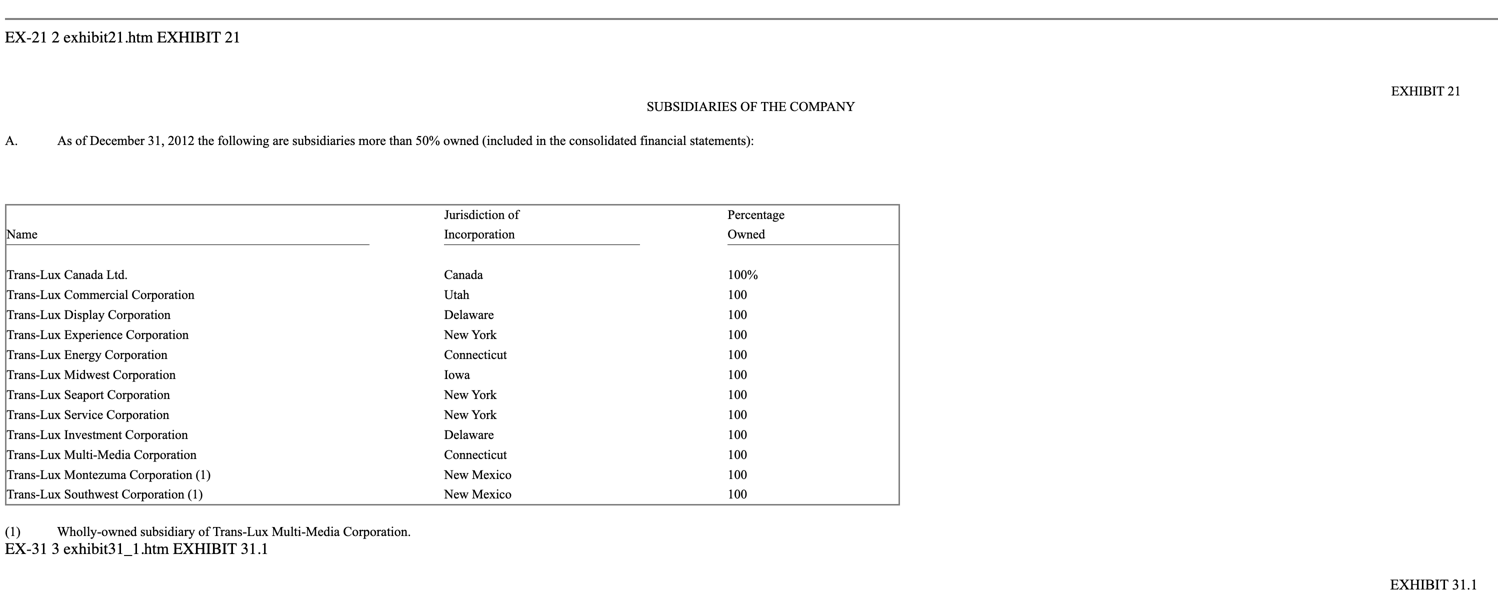

In [34]:
image = Image.open("trans_lux_corp.png").convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [35]:
feature_extractor = DetrImageProcessor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [36]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 536, 1333])


# Forward Pass

In [37]:
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
with torch.no_grad():
    outputs = model(**encoding)

In [53]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(id2label, pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
     

In [54]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

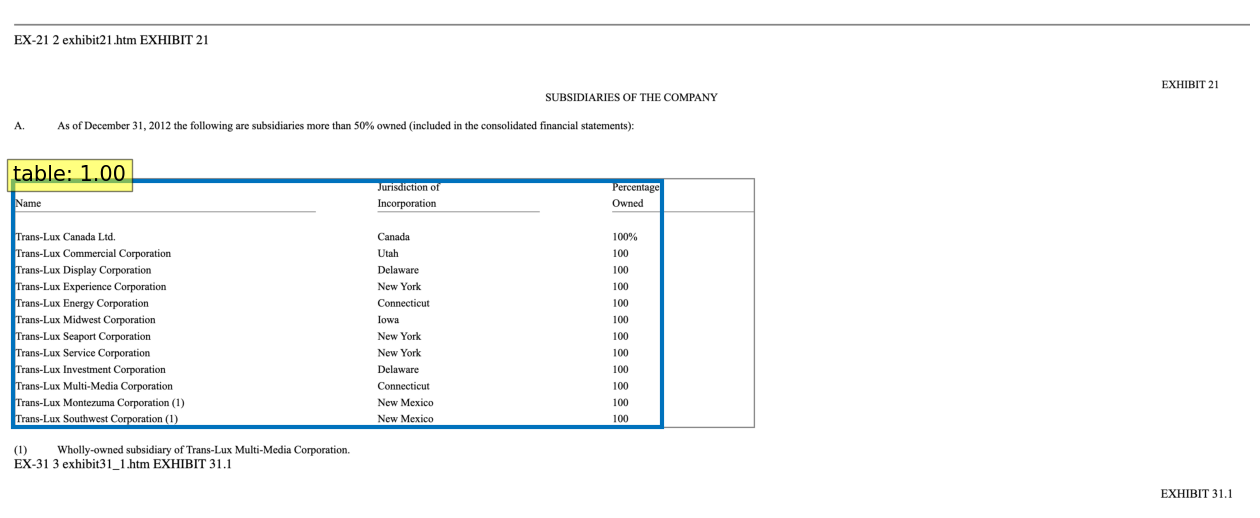

In [55]:
plot_results(model.config.id2label, image, results['scores'], results['labels'], results['boxes'])

In [56]:
# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

In [57]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [58]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [59]:
objects

[{'label': 'table',
  'score': 0.9986737966537476,
  'bbox': [6.905336380004883,
   413.5126037597656,
   1575.0552978515625,
   1007.705078125]}]

In [94]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

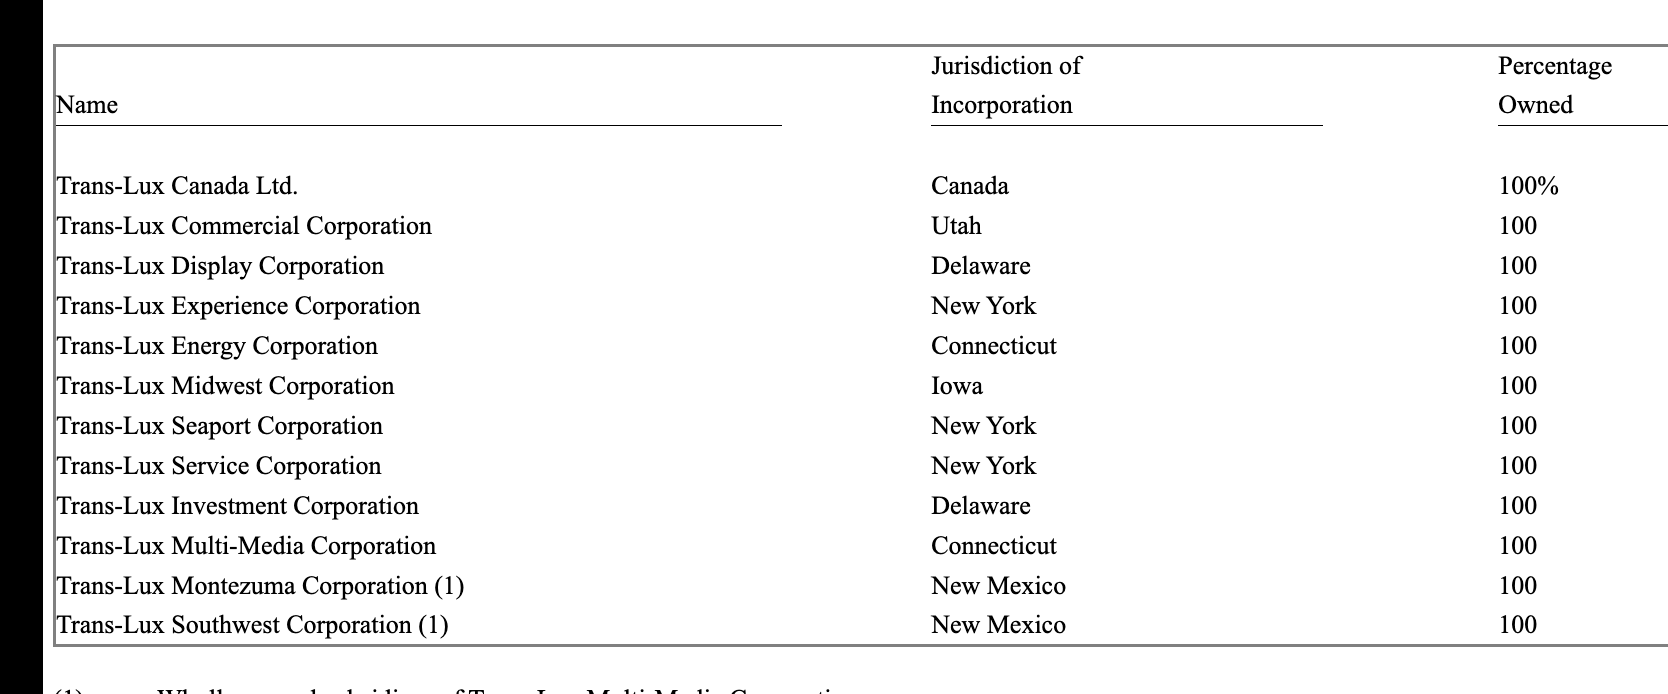

In [100]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 50

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=crop_padding)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [36]:
cropped_table.save("trans_lux_corp_table.png")

# Table Structure Recognition

In [78]:
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
with torch.no_grad():
    outputs = structure_model(**encoding)

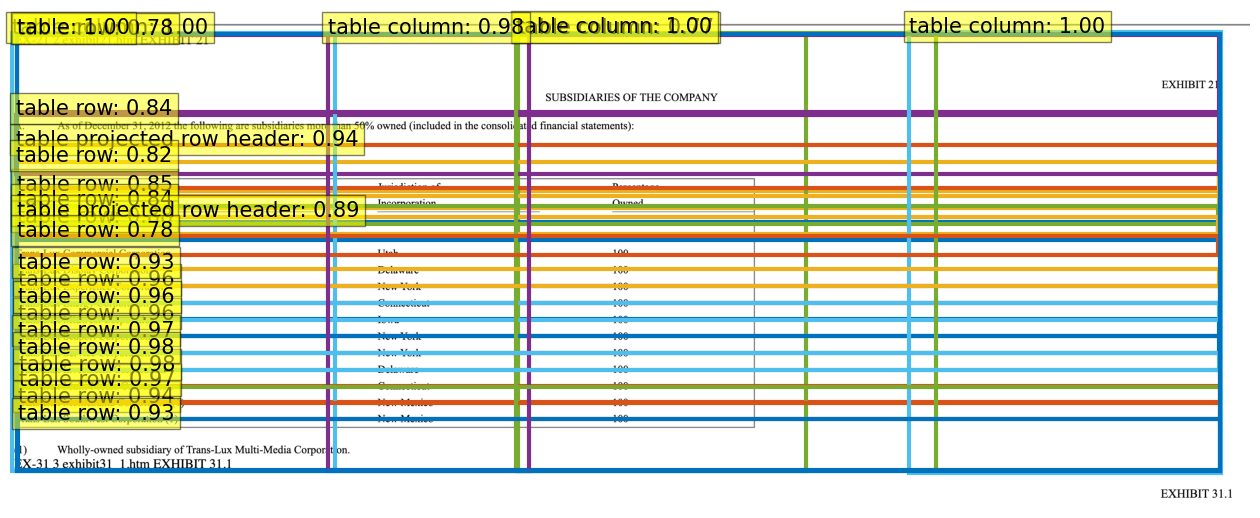

In [80]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(structure_model.config.id2label, image, results['scores'], results['labels'], results['boxes'])

In [81]:
structure_model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [82]:
last_hidden_states = outputs.last_hidden_state
# these are of shape (batch_size, num_queries, hidden_size)
list(last_hidden_states.shape)

[1, 125, 256]

# Try structure recognition on cropped image

In [101]:
encoding = feature_extractor(cropped_table, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [102]:
with torch.no_grad():
    outputs = structure_model(**encoding)

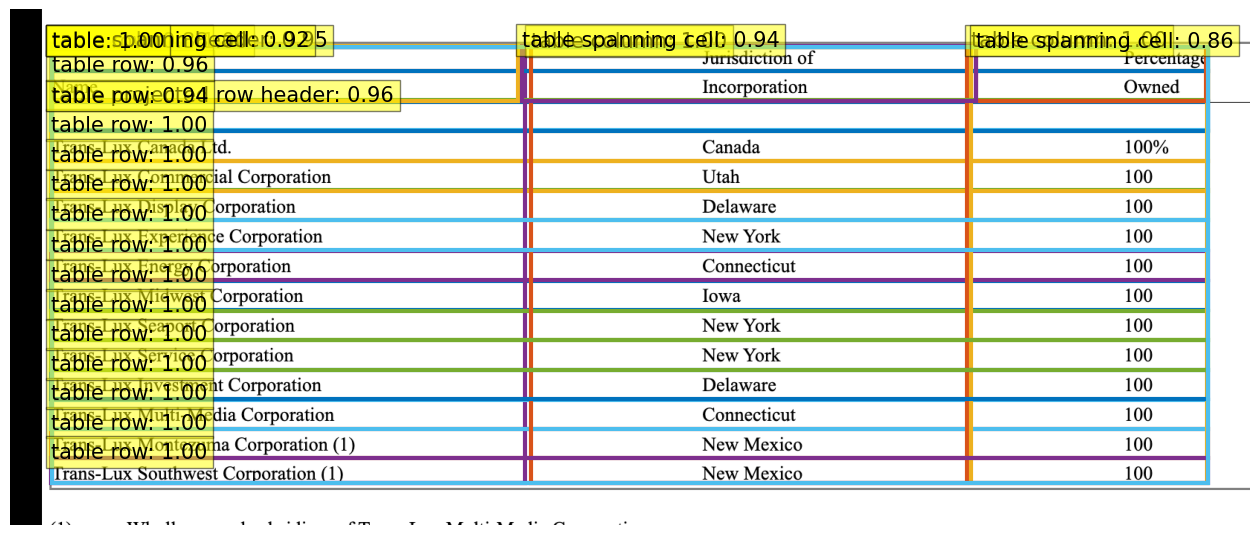

In [103]:
target_sizes = [cropped_table.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(structure_model.config.id2label, cropped_table, results['scores'], results['labels'], results['boxes'])

# Extract into a dataframe

* https://iamrajatroy.medium.com/document-intelligence-series-part-2-transformer-for-table-detection-extraction-80a52486fa3 might be helpful

In [16]:
!pip install -q easyocr

In [104]:
def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [105]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)

In [106]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [107]:
len(cell_coordinates)

15

In [108]:
len(cell_coordinates[0]["cells"])

3

In [109]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))
            # apply OCR
            result = reader.readtext(np.array(cell_image))
            if len(result) > 0:
                # print([x[1] for x in list(result)])
                text = " ".join([x[1] for x in result])
                row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

  0%|          | 0/15 [00:00<?, ?it/s]

Max number of columns: 3
['Jurisdiction of', 'Percentage', '']
['Name', 'Incorporation', 'Owned']
['', '', '']
['Trans-Lux Canada Ltd.', 'Canada', '100%']
['Trans-Lux Commercial Corporation', 'Utah', '100']
['Trans-Lux Display Corporation', 'Delaware', '100']
['Trans-Lux Experience Corporation', 'New York', '100']
['Trans-Lux Energy Corporation', 'Connecticut', '100']
['Trans-Lux Midwest Corporation', 'Iowa', '100']
['Trans-Lux Seaport Corporation', 'New York', '100']
['Trans-Lux Service Corporation', 'New York', '100']
['Trans-Lux Investment Corporation', 'Delaware', '100']
['Trans-Lux Multi-Media Corporation', 'Connecticut', '100']
['Trans-Lux Montezuma Corporation (1)', 'New Mexico', '100']
['Trans-Lux Southwest Corporation (1)', 'New Mexico', '100']


In [115]:
data

{0: ['Jurisdiction of', 'Percentage', ''],
 1: ['Name', 'Incorporation', 'Owned'],
 2: ['', '', ''],
 3: ['Trans-Lux Canada Ltd.', 'Canada', '100%'],
 4: ['Trans-Lux Commercial Corporation', 'Utah', '100'],
 5: ['Trans-Lux Display Corporation', 'Delaware', '100'],
 6: ['Trans-Lux Experience Corporation', 'New York', '100'],
 7: ['Trans-Lux Energy Corporation', 'Connecticut', '100'],
 8: ['Trans-Lux Midwest Corporation', 'Iowa', '100'],
 9: ['Trans-Lux Seaport Corporation', 'New York', '100'],
 10: ['Trans-Lux Service Corporation', 'New York', '100'],
 11: ['Trans-Lux Investment Corporation', 'Delaware', '100'],
 12: ['Trans-Lux Multi-Media Corporation', 'Connecticut', '100'],
 13: ['Trans-Lux Montezuma Corporation (1)', 'New Mexico', '100'],
 14: ['Trans-Lux Southwest Corporation (1)', 'New Mexico', '100']}

In [126]:
columns = ["Name", "Jurisdiction of Incorporation", "Percentage Owned"]
data_rows = []
for i in range(3, len(data)):
    data_rows.append(data[i])
df = pd.DataFrame(columns=columns, data=data_rows)
df

,Name,Jurisdiction of Incorporation,Percentage Owned
0,Trans-Lux Canada Ltd.,Canada,100%
1,Trans-Lux Commercial Corporation,Utah,100
2,Trans-Lux Display Corporation,Delaware,100
3,Trans-Lux Experience Corporation,New York,100
4,Trans-Lux Energy Corporation,Connecticut,100
5,Trans-Lux Midwest Corporation,Iowa,100
6,Trans-Lux Seaport Corporation,New York,100
7,Trans-Lux Service Corporation,New York,100
8,Trans-Lux Investment Corporation,Delaware,100
9,Trans-Lux Multi-Media Corporation,Connecticut,100


# Fine Tuning Table Transformer Model

* Goal is to fine tune the model so that it only detects and extracts Ex. 21 tables

- [x] Walk through fine tuning tutorial
- [ ] Check out PubTables and FinTabNet as suggested by below issue
- [ ] Try fine-tuning with a proprietary dataset
- [ ] Figure out how to create label dataframe
- [ ] Create training data to fine tune with

Notes/Ideas:
* check the [Pad and Multimodal](https://huggingface.co/docs/transformers/en/preprocessing#multimodal) sections of the Preprocessing tutorial
  * Seems like padding the images could be helpful for fine tuning
  * Inputs for fine tuning could be multimodal, HTML text and image version of text
* "Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better."
* https://github.com/microsoft/table-transformer/issues/127
* https://github.com/NielsRogge/Transformers-Tutorials/issues/316
* https://developer.ibm.com/exchanges/data/all/fintabnet/

# Facebook RAG Extractor

In [ ]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration

In [ ]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration
import torch

# Load the tokenizer and retriever
tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
retriever = RagRetriever.from_pretrained("facebook/rag-token-base")

# Load the generator
generator = RagTokenForGeneration.from_pretrained("facebook/rag-token-base")

# Your HTML content
html_content = "Your HTML content here"

# Retrieve relevant tables from the HTML content
relevant_tables = retriever.retrieve([html_content])

# Extract information from tables
for table in relevant_tables:
    # Tokenize the table
    input_ids = tokenizer(table, return_tensors="pt")["input_ids"]
    # Generate output
    outputs = generator.generate(input_ids)
    # Decode the output
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(decoded_output)

In [ ]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration, Trainer, TrainingArguments
import torch
import datasets

# Load the pre-trained tokenizer and retriever
tokenizer = RagTokenizer.from_pretrained("facebook/rag-token-base")
retriever = RagRetriever.from_pretrained("facebook/rag-token-base")

# Load your dataset
dataset = datasets.load_dataset("your_dataset")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    logging_dir="./logs",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
)

# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
trainer.evaluate()


In [2]:
# training dataset compatible with Trainer API?